# **Survival Rate Analysis in Shrimp Farming**

## **1. Background**
Shrimp farming is a key sector in aquaculture, contributing significantly to global seafood production. However, maintaining a **high survival rate (SR)** remains a challenge due to various environmental and management factors. Poor water quality, inadequate feeding strategies, and disease outbreaks can lead to high mortality, reducing overall farm profitability.

To optimize survival rates, it is crucial to develop a **predictive model** that can estimate SR based on available farm data. This will enable shrimp farmers to make data-driven decisions and improve management strategies, ultimately increasing production efficiency.

## **2. Problem Statement**
Despite technological advancements in aquaculture, many shrimp farms still experience high mortality rates due to:
- **Unstable water quality** (temperature, dissolved oxygen, pH, salinity, ammonia levels, etc.).
- **Inefficient feeding practices**, leading to either overfeeding or underfeeding.
- **Suboptimal farm management**, including poor stocking density or inadequate monitoring.

Given the complexity of these factors, a data-driven approach is necessary to identify key predictors of survival rate and develop a reliable forecasting model.

## **3. Objective**
This study aims to:
1. Analyze historical shrimp farming data to identify key factors influencing **Survival Rate (SR)**.
2. Build a predictive model to estimate **SR at the end of each cycle**.
3. Provide actionable insights for farm management to **enhance shrimp survival**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import time
import missingno

## **4. Dataset Description**
The dataset consists of multiple tables capturing different aspects of shrimp farming operations:

**Farms**
| Feature     | Description                              |
|------------|------------------------------------------|
| `id`       | Unique ID for each farm.                |
| `province` | Province where the farm is located.     |
| `regency`  | Regency/city where the farm is located. |
| `timezone` | Farm's timezone.                        |

---

**Ponds**
| Feature   | Description                              |
|----------|------------------------------------------|
| `id`     | Unique ID for each pond.                |
| `length` | Pond length (meters).                   |
| `width`  | Pond width (meters).                    |
| `deep`   | Pond depth (meters).                    |
| `farm_id` | Foreign key to `farms.id`.            |

---

**Cycles**
| Feature      | Description                              |
|------------|------------------------------------------|
| `id`       | Unique ID for each cultivation cycle.   |
| `started_at` | Start date of the cycle.             |
| `finished_at` | End date of the cycle.              |
| `total_seed` | Number of seeds stocked (shrimp).    |
| `area`     | Pond area in square meters.            |
| `pond_id`  | Foreign key to `ponds.id`.             |

---

**Feeds**
| Feature     | Description                              |
|------------|------------------------------------------|
| `cycle_id` | Foreign key to `cycles.id`.             |
| `logged_at` | Feed logging time (UTC).               |
| `quantity` | Amount of feed given (kg).             |

---

**Fasting**
| Feature       | Description                              |
|-------------|------------------------------------------|
| `cycle_id`  | Foreign key to `cycles.id`.             |
| `logged_date` | Date of fasting period.              |
| `fasting`   | Boolean (1: fasting, 0: not fasting).  |

---

**Harvests**
| Feature      | Description                              |
|------------|------------------------------------------|
| `cycle_id`  | Foreign key to `cycles.id`.             |
| `harvested_at` | Harvest date.                       |
| `status`    | Harvest status (e.g., "partial" or "final"). |
| `size`      | Shrimp size (shrimp/kg).               |
| `weight`    | Total harvest weight (kg).            |

---

**Sampling**
| Feature        | Description                              |
|-------------|------------------------------------------|
| `cycle_id`  | Foreign key to `cycles.id`.             |
| `sampled_at` | Sampling date.                         |
| `average_weight` | Average shrimp weight in sample (grams). |

---

**Measurements**
| Feature            | Description                              |
|------------------|------------------------------------------|
| `cycle_id`      | Foreign key to `cycles.id`.             |
| `measured_at`   | Measurement date.                       |
| `morning_temperature` | Morning water temperature (°C).  |
| `evening_temperature` | Evening water temperature (°C).  |
| `morning_do`    | Morning dissolved oxygen (ppm).         |
| `evening_do`    | Evening dissolved oxygen (ppm).         |
| `morning_salinity` | Morning salinity (ppt).             |
| `evening_salinity` | Evening salinity (ppt).             |
| `morning_pH`    | Morning pH level.                      |
| `evening_pH`    | Evening pH level.                      |
| `transparency`  | Water transparency (cm).               |
| `ammonia`       | Ammonia concentration (ppm).           |
| `nitrate`       | Nitrate concentration (ppm).           |
| `nitrite`       | Nitrite concentration (ppm).           |
| `alkalinity`    | Alkalinity concentration (ppm).        |
| `hardness`      | Water hardness (ppm).                  |
| `calcium`       | Calcium concentration (ppm).           |
| `magnesium`     | Magnesium concentration (ppm).         |
| `carbonate`     | Carbonate concentration (ppm).         |
| `bicarbonate`   | Bicarbonate concentration (ppm).       |
| `tom`          | Total Organic Matter (TOM) concentration (ppm). |
| `total_plankton_` | Total plankton concentration.        |

---

**Mortalities**
| Feature      | Description                              |
|------------|------------------------------------------|
| `cycle_id`  | Foreign key to `cycles.id`.             |
| `quantity`  | Estimated number of shrimp deaths.      |
| `recorded_at` | Mortality record date.               |
| `average_weight` | Average shrimp weight at death (grams). |

---

**Feed Tray**
| Feature      | Description                              |
|------------|------------------------------------------|
| `cycle_id`  | Foreign key to `cycles.id`.             |
| `logged_at` | Feed tray logging date and time.        |
| `feed_logged_at` | Feed given date and time.         |
| `tray_number` | Tray number (1-4 per pond).          |
| `feed_remaining_percent` | Remaining feed percentage (%). |
| `remark`   | Notes on tray condition or shrimp feeding behavior. |


## 5. Exploratory Data Analysis

**Farm Dataset**

In [2]:
# Load datasets
farms = pd.read_csv('farms.csv')
farms

,id,province,regency,timezone
0,652,JAWA BARAT,SUBANG,+07:00
1,869,SULAWESI SELATAN,BARRU,+08:00
2,900,JAWA TIMUR,PACITAN,+07:00
3,1000,JAWA TIMUR,SITUBONDO,+07:00
4,1106,JAWA TIMUR,BANYUWANGI,+07:00
...,...,...,...,...
546,13692,OUTSIDE INDONESIA,NaN,+07:00
547,13743,BALI,KARANG ASEM,+08:00
548,13788,JAWA TIMUR,JEMBER,+07:00
549,13876,JAWA TIMUR,BANYUWANGI,+07:00


In [3]:
df = farms

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.00,551,"[8316, 10480]"
1,province,object,72,13.07,20,"[JAWA TENGAH, JAWA BARAT]"
2,regency,object,93,16.88,67,"[LAMPUNG SELATAN, PASURUAN]"
3,timezone,object,0,0.00,6,"[+08:00, +06:00]"


**Pond Dataset**

In [4]:
ponds = pd.read_csv('ponds.csv')
ponds

,id,farm_id,length,width,deep,created_at,updated_at,record_id,extracted_at,max_seed_density
0,2117,8,NaN,NaN,NaN,2018-04-19 20:09:43.000,2018-04-19 20:09:43.000,ponds_2023_12_21_2117,2023-12-21 17:02:10.000,NaN
1,9,3,16.70,36.20,NaN,2018-03-07 19:05:09.000,2018-03-15 00:58:08.000,ponds_2024_4_12_9,2024-04-12 17:02:11.000,NaN
2,2116,8,NaN,NaN,NaN,2018-04-19 20:09:43.000,2018-04-19 20:09:43.000,ponds_2023_12_21_2116,2023-12-21 17:02:10.000,NaN
3,7,3,46.50,32.60,1.1,2018-03-07 19:05:09.000,2018-03-15 00:51:55.000,ponds_2024_4_12_7,2024-04-12 17:02:11.000,131.926121
4,8,3,48.50,33.00,1.1,2018-03-07 19:05:09.000,2022-05-28 13:31:07.000,ponds_2024_4_12_8,2024-04-12 17:02:11.000,124.921924
...,...,...,...,...,...,...,...,...,...,...
333,44514,12530,31.00,30.00,1.3,2023-10-10 05:40:12.000,2023-10-10 05:40:12.000,ponds_2023_10_11_44514,2023-10-11 17:02:18.000,129.032258
334,37697,9987,81.65,61.24,NaN,2022-12-23 06:33:28.000,2022-12-23 06:33:28.000,ponds_2024_4_12_37697,2024-04-12 17:02:11.000,0.012000
335,44579,12542,21.00,14.00,1.3,2023-10-12 01:56:21.000,2023-10-12 01:56:21.000,ponds_2024_4_12_44579,2024-04-12 17:02:11.000,NaN
336,44613,12553,40.00,40.00,1.5,2023-10-14 03:18:53.000,2023-10-14 03:23:49.000,ponds_2024_4_12_44613,2024-04-12 17:02:11.000,168.750000


In [5]:
df = ponds

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.00,338,"[44663, 44615]"
1,farm_id,int64,0,0.00,70,"[7370, 12569]"
2,length,float64,23,6.80,69,"[32.0, 28.2]"
3,width,float64,29,8.58,76,"[40.01, 8.0]"
4,deep,float64,92,27.22,19,"[nan, 1.2]"
5,created_at,object,0,0.00,142,"[2023-10-13 05:28:55.000, 2023-10-15 01:52:26...."
6,updated_at,object,0,0.00,177,"[2023-10-21 04:33:47.000, 2023-10-18 02:33:17...."
7,record_id,object,0,0.00,338,"[ponds_2024_4_12_27133, ponds_2024_4_12_45041]"
8,extracted_at,object,0,0.00,16,"[2022-07-18 17:02:18.000, 2022-10-24 17:02:17...."
9,max_seed_density,float64,203,60.06,94,"[157.19697, 0.080563]"


**Cycles Dataset**

In [6]:
cycles = pd.read_csv('cycles.csv')
cycles

,id,pond_id,species_id,total_seed,started_at,finished_at,remark,created_at,updated_at,area,...,extracted_at,subscription_type,ordered_at,hatchery_id,total_seed_type,hatchery_name,pond_name,pond_length,pond_width,pond_depth
0,18876,36294,1.0,331920,2022-10-14 00:00:00.000,2023-01-29 00:00:00.000,NaN,2022-10-14 12:34:23.000,2023-01-30 01:46:27.000,4030.0,...,2024-04-12 17:02:22.000,Free,NaN,66.0,net,UD. Benur Ndaru Laut,H,65.00,62.00,1.0
1,22118,37102,1.0,40000,2023-04-26 00:00:00.000,2023-06-23 00:00:00.000,#TBR01,2023-04-30 22:28:13.000,2023-06-26 05:35:32.000,399.0,...,2024-04-12 17:02:22.000,Free,NaN,83.0,net,CV Raja Benur,A1,30.00,20.00,1.0
2,24088,39154,NaN,357570,2023-08-01 00:00:00.000,2023-10-18 00:00:00.000,#SiklusFarm,2023-07-12 01:13:05.000,2023-10-19 04:23:11.000,2000.0,...,2024-04-12 17:02:22.000,Free,2023-07-12 01:13:05.000,1004.0,gross,PT. Tri Karta Pratama - Total Kualitas Prima,A3,50.00,40.00,1.4
3,17743,20914,1.0,168275,2022-07-19 00:00:00.000,2022-09-29 00:00:00.000,#SiklusCustomerPermadi,2022-08-14 04:40:46.000,2022-10-06 00:09:36.000,1512.0,...,2024-04-12 17:02:22.000,Free,NaN,3.0,actual,PT. Central Proteinaprima Tbk,B4,54.00,28.00,1.5
4,17125,34187,1.0,188000,2022-07-07 00:00:00.000,2022-09-20 00:00:00.000,#SiklusTebar,2022-07-12 00:24:30.000,2022-10-15 04:27:24.000,1225.0,...,2024-04-12 17:02:22.000,Free,2022-07-12 00:24:30.000,35.0,net,PT Windu Alam Sentosa,A,35.00,35.00,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,19131,34712,2.0,300000,2022-10-25 00:00:00.000,2023-01-21 00:00:00.000,NaN,2022-10-25 10:13:31.000,2023-01-25 08:01:19.000,4999.9,...,2024-04-12 17:02:22.000,Free,NaN,1020.0,actual,MATERNIDADE NACALA,E01,70.71,70.71,1.5
2613,27552,45697,1.0,100000,2023-11-05 00:00:00.000,2024-02-13 00:00:00.000,#TBR03,2023-11-18 03:43:40.000,2024-03-27 02:52:36.000,900.0,...,2024-04-12 17:02:22.000,Free,2023-11-18 03:43:40.000,1022.0,net,Windu Segara Anyar,Kolam 4,45.00,20.00,1.5
2614,27885,24570,1.0,30716,2023-12-02 00:00:00.000,2024-02-29 00:00:00.000,#TBR05,2023-12-03 03:06:01.000,2024-03-03 03:03:26.000,86.0,...,2024-04-12 17:02:22.000,Free,NaN,83.0,gross,CV Raja Benur,Bagus,10.71,8.03,1.0
2615,15868,32398,1.0,150000,2022-04-28 00:00:00.000,2022-06-21 00:00:00.000,#SiklusTebar,2022-05-08 16:02:51.000,2022-08-23 03:12:20.000,1600.0,...,2024-04-12 17:02:22.000,Free,2022-05-08 16:02:51.000,35.0,gross,PT Windu Alam Sentosa,B 4.1,45.00,35.00,2.0


In [7]:
df = cycles

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.00,2500,"[16428, 19169]"
1,pond_id,int64,0,0.00,1675,"[40601, 14335]"
2,species_id,float64,814,31.10,2,"[nan, 2.0]"
3,total_seed,int64,0,0.00,868,"[108000, 347100]"
4,started_at,object,0,0.00,750,"[2022-08-01 00:00:00.000, 2020-12-09 00:00:00...."
5,finished_at,object,1,0.04,857,"[2023-10-13 00:00:00.000, 2023-09-27 00:00:00...."
6,remark,object,1281,48.95,67,"[#BD-Katalis08, #SiklusTebarSebelumnya]"
7,created_at,object,0,0.00,2325,"[2022-08-09 09:25:40.000, 2022-10-01 07:51:29...."
8,updated_at,object,0,0.00,2289,"[2023-05-17 09:07:31.000, 2023-10-23 02:31:00...."
9,area,float64,0,0.00,648,"[1194.0, 1350.0]"


**Relations of Cycles, Ponds and Farm**

Each cycle (cycles) must be linked to a pond (ponds), and each pond must belong to a farm (farms).


To ensure the integrity of these relationships, we need to perform layered inner joins:
- Join cycles with ponds → Verifies that all cycles are associated with a valid pond.
- Join the result with farms → Ensures that the ponds used in the cycles genuinely belong to an existing farm.

In [8]:
# 1. Join Farms with Ponds (Check if all ponds are linked to a farm)
farms_ponds = farms.merge(ponds, left_on="id", right_on="farm_id", how="inner")
print(f"Total number of ponds: {len(ponds)}, after joining with farms: {len(farms_ponds)}")

# 2. Join Ponds with Cycles (Check if all cycles are linked to a pond)
ponds_cycles = ponds.merge(cycles, left_on="id", right_on="pond_id", how="inner")
print(f"Total number of cycles: {len(cycles)}, after joining with ponds: {len(ponds_cycles)}")

# 3. Merge all tables (Verify if all cycles are correctly linked to farms through ponds)
farms_ponds_cycles = farms_ponds.merge(cycles, left_on="id_y", right_on="pond_id", how="inner")
print(f"Total number of cycles: {len(cycles)}, after joining with farms & ponds: {len(farms_ponds_cycles)}")


Total number of ponds: 338, after joining with farms: 25
Total number of cycles: 2617, after joining with ponds: 51
Total number of cycles: 2617, after joining with farms & ponds: 23


It appears that only a few farms/ponds contain valid data across the tables. This suggests that the dataset might be a small subset of the original database.

**Feeds Dataset**

In [9]:
feeds = pd.read_csv('feeds.csv')
feeds

,cycle_id,logged_at,quantity
0,15013,2022-03-29 00:00:00.000,0.5
1,15013,2022-03-29 05:30:00.000,0.5
2,15013,2022-03-29 11:30:00.000,0.5
3,15013,2022-03-29 14:30:00.000,0.5
4,15013,2022-03-30 00:00:00.000,0.5
...,...,...,...
706903,24650,2023-09-15 21:47:00.000,10.0
706904,24650,2023-09-19 00:00:00.000,13.2
706905,24650,2023-09-20 00:00:00.000,14.0
706906,24650,2023-09-21 13:54:00.000,10.0


In [10]:
df = feeds

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,cycle_id,int64,0,0.0,2500,"[17031, 19483]"
1,logged_at,object,21,0.0,74841,"[2021-06-05 08:00:00.000, 2023-03-11 01:00:00...."
2,quantity,float64,21,0.0,6404,"[12.98, 3.62]"


**Fasting Dataset**

In [11]:
fasting = pd.read_csv('fasting.csv')
fasting

,logged_date,cycle_id,fasting
0,2022-10-17,15804,1.0
1,2022-11-27,15804,0.0
2,2022-11-28,15804,0.0
3,2022-11-29,15804,0.0
4,2022-12-01,15804,1.0
...,...,...,...
6184,2023-03-09,15301,1.0
6185,2023-03-15,15301,1.0
6186,2023-03-23,15301,1.0
6187,2023-04-06,15301,1.0


In [12]:
df = fasting

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,logged_date,object,0,0.00,479,"[2023-05-18, 2022-08-13]"
1,cycle_id,int64,0,0.00,339,"[17743, 18149]"
2,fasting,float64,17,0.27,2,"[nan, 0.0]"


**Harvest Dataset**

In [13]:
harvests = pd.read_csv('harvests.csv')
harvests

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
0,15013.0,2022-07-18 08:42:59,399.86,2022-07-18 08:42:59,0.01,11960.0,2022-04-17,Failed,NaN
1,11848.0,2021-10-25 23:29:53,300.00,2021-10-24 08:38:53,46.00,7520.0,2021-10-22,Full,1610000.0
2,11848.0,2021-10-25 23:29:35,300.00,2021-10-25 23:29:35,10.00,7546.0,2021-10-21,Partial,350000.0
3,4666.0,2020-10-08 02:07:18,110.00,2020-10-08 02:07:18,270.50,3009.0,2020-08-31,Failed,NaN
4,4666.0,2020-10-08 02:07:37,190.00,2020-10-08 02:07:37,270.50,3010.0,2020-08-31,Failed,NaN
...,...,...,...,...,...,...,...,...,...
8082,28500.0,2024-03-17 06:34:46,90.00,2024-03-14 05:43:03,12.00,27731.0,2024-03-05,Full,720000.0
8083,28500.0,2024-03-17 06:31:41,150.00,2024-03-14 05:47:06,4.00,27732.0,2024-02-02,Partial,280000.0
8084,11741.0,2022-10-06 05:23:38,80.00,2021-11-22 05:44:13,183.00,8252.0,2021-11-20,Full,10431000.0
8085,11741.0,2022-10-06 05:23:39,80.00,2021-11-22 05:55:49,30.00,8254.0,2021-11-20,Partial,1200000.0


In [14]:
df = harvests

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,cycle_id,float64,0,0.00,2490,"[26477.0, 26253.0]"
1,updated_at,object,0,0.00,5892,"[2024-03-07 15:05:22, 2023-11-30 10:20:51]"
2,size,float64,0,0.00,1481,"[46.52, 217.5]"
3,created_at,object,0,0.00,7098,"[2023-11-23 12:56:29, 2023-05-23 05:58:45]"
4,weight,float64,0,0.00,5109,"[957.16, 516.14]"
5,id,float64,0,0.00,8076,"[26364.0, 21392.0]"
6,harvested_at,object,0,0.00,1069,"[2023-04-05, 2022-03-27]"
7,status,object,263,3.25,13,"[Transfer ke N1 dan N2, finishing (pengesatan)]"
8,selling_price,float64,1793,22.17,4981,"[2407104.0, 19123200.0]"


In [15]:
harvests['status'].unique()

array(['Failed', 'Full', 'Partial', nan, 'FINISIHING',
       'Transfer ke N1 dan N2', 'Transfer ke 10', 'Transfer ke 9',
       'Transfer ke 8', 'finishing (pengesatan)', 'Parsial', 'Patial',
       'Transfer', 'Transfer ke Tambak'], dtype=object)

In [16]:
harvests[harvests['status']=='FINISIHING']

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
803,19518.0,2023-03-11 04:49:15,43.8,2023-03-11 04:49:15,14.0,16628.0,2023-03-11,FINISIHING,0.0


In [17]:
harvests[harvests['status']=='Full']

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
1,11848.0,2021-10-25 23:29:53,300.0,2021-10-24 08:38:53,46.00,7520.0,2021-10-22,Full,1.610000e+06
5,18747.0,2022-10-20 01:06:50,72.3,2022-10-20 01:06:50,5322.28,13876.0,2022-10-19,Full,5.322280e+03
6,27095.0,2024-02-19 02:10:48,41.5,2023-12-27 12:00:59,7843.00,25322.0,2023-12-12,Full,4.925404e+08
12,23633.0,2023-12-20 06:31:58,20.7,2023-12-09 10:44:34,4576.00,24888.0,2023-12-09,Full,NaN
13,25920.0,2024-02-28 09:34:16,22.8,2024-02-28 09:34:16,1624.00,27340.0,2024-02-26,Full,NaN
...,...,...,...,...,...,...,...,...,...
8023,27763.0,2024-02-13 03:17:20,56.3,2024-02-13 03:17:20,4047.50,26784.0,2024-01-30,Full,NaN
8025,25578.0,2023-12-16 09:15:34,118.0,2023-11-16 07:48:11,80.00,24001.0,2023-11-13,Full,3.360000e+06
8082,28500.0,2024-03-17 06:34:46,90.0,2024-03-14 05:43:03,12.00,27731.0,2024-03-05,Full,7.200000e+05
8084,11741.0,2022-10-06 05:23:38,80.0,2021-11-22 05:44:13,183.00,8252.0,2021-11-20,Full,1.043100e+07


In [18]:
harvests[harvests['status']=='Patial']

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
5276,21167.0,2023-05-20 04:59:36,73.0,2023-05-20 04:59:36,18.0,18024.0,2023-05-20,Patial,NaN


In [19]:
harvests[harvests['status']=='Partial']

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
2,11848.0,2021-10-25 23:29:35,300.00,2021-10-25 23:29:35,10.0,7546.0,2021-10-21,Partial,350000.0
7,27095.0,2024-02-19 02:08:11,67.50,2024-02-12 05:06:57,1244.5,26728.0,2023-11-08,Partial,76536750.0
8,27095.0,2024-02-19 02:08:08,176.00,2024-02-12 05:06:57,5.0,26729.0,2023-11-08,Partial,135000.0
9,27095.0,2024-02-19 02:08:07,67.50,2024-02-12 05:06:58,2.0,26735.0,2023-11-08,Partial,92250.0
18,16343.0,2022-08-16 08:29:44,89.23,2022-08-16 08:29:44,424.9,12532.0,2022-07-20,Partial,NaN
...,...,...,...,...,...,...,...,...,...
8079,28500.0,2024-03-17 06:33:41,150.00,2024-03-14 05:39:25,1.5,27728.0,2024-02-18,Partial,90000.0
8080,28500.0,2024-03-17 06:33:41,150.00,2024-03-14 05:39:58,1.0,27729.0,2024-02-18,Partial,60000.0
8081,28500.0,2024-03-17 06:33:41,150.00,2024-03-14 05:40:28,2.0,27730.0,2024-02-18,Partial,120000.0
8083,28500.0,2024-03-17 06:31:41,150.00,2024-03-14 05:47:06,4.0,27732.0,2024-02-02,Partial,280000.0


In [20]:
harvests["cycle_id"] = harvests["cycle_id"].astype("Int64")

After examining the `harvests` table, we found that it contains multiple harvest events for some cycles. These events can have different statuses, such as **"Partial"**, **"Other"**, and **"Full"**.  

- **Partial or Other Status Harvests:**  
  - These indicate that only a portion of the shrimp population was harvested.  
  - The remaining shrimp continue to grow, making it **impossible to determine the true survival rate** at the end of the cycle.  
  - Including these records in the model could introduce noise and lead to misleading predictions.  

- **Full Harvest:**  
  - This represents the **final** harvesting stage where all remaining shrimp in the pond are collected.  
  - Since our goal is to predict **Survival Rate (SR) at the end of the cycle**, this is the only status that provides an accurate ground truth.  

**Measurements**

In [21]:
measurements = pd.read_csv('measurements.csv')
measurements

,pond_id,cycle_id,measured_date,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,evening_salinity,morning_pH,...,nitrate,nitrite,alkalinity,hardness,calcium,magnesium,carbonate,bicarbonate,tom,total_plankton_
0,31250,15009,2022-04-16,29.000,NaN,NaN,NaN,28.000,NaN,8.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21226,10897,2021-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45694,27893,2023-12-07,29.342,32.445,4.355,6.253,2.155,2.686,8.294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34732,17637,2022-08-11,24.900,25.900,5.100,3.800,21.000,NaN,7.400,...,NaN,0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,19874,2023-04-04,28.211,30.869,3.106,4.370,12.673,12.041,7.911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139045,31457,19061,2022-12-22,27.000,30.000,NaN,NaN,24.000,NaN,7.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139046,31457,19061,2023-01-17,27.000,29.000,NaN,NaN,23.000,NaN,7.600,...,NaN,1.892,100.0,4500.0,400.0,996.0,0.0,100.0,107.0,822500.0
139047,11,6126,2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139048,44169,26483,2024-01-21,26.873,29.046,4.947,4.940,32.236,30.958,7.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = measurements

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,pond_id,int64,0,0.00,1675,"[45206, 21240]"
1,cycle_id,int64,0,0.00,2500,"[11638, 27109]"
2,measured_date,object,0,0.00,1427,"[2021-12-09, 2023-03-22]"
3,morning_temperature,float64,41855,30.10,4793,"[27.6195, 30.644]"
4,evening_temperature,float64,49839,35.84,5386,"[32.381, 29.422]"
5,morning_do,float64,61324,44.10,6531,"[6.818, 2.638]"
6,evening_do,float64,65098,46.82,7706,"[3.786, 3.087]"
7,morning_salinity,float64,46388,33.36,19113,"[36.255, 10.585]"
8,evening_salinity,float64,73957,53.19,18407,"[30.81, 17.784]"
9,morning_pH,float64,20115,14.47,3190,"[8.984, 6.403]"


**Mortalities**

In [23]:
mortalities = pd.read_csv('mortalities.csv')
mortalities

,id,cycle_id,quantity,recorded_at,created_at,updated_at,average_weight
0,185,8007,83334,2021-03-04,2021-03-04 03:46:42,2024-01-08 11:40:40,1.50
1,186,8007,43334,2021-03-05,2021-03-05 06:47:30,2024-01-08 11:40:40,1.50
2,188,8139,870,2021-03-04,2021-03-11 09:00:34,2024-01-08 11:40:40,3.45
3,189,8139,1160,2021-03-05,2021-03-11 09:02:41,2024-01-08 11:40:40,3.45
4,190,8139,2030,2021-03-07,2021-03-11 09:03:27,2024-01-08 11:40:40,3.45
...,...,...,...,...,...,...,...
13216,26188,27415,2565,2024-03-31,2024-04-03 06:39:15,2024-04-03 06:39:15,17.54
13217,26189,27415,2850,2024-04-01,2024-04-03 06:39:49,2024-04-03 06:39:49,17.54
13218,26190,27415,1425,2024-04-02,2024-04-03 06:40:05,2024-04-03 06:40:05,17.54
13219,26191,27416,898,2024-03-29,2024-04-03 06:40:39,2024-04-03 06:40:39,15.87


In [24]:
df = mortalities

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.0,13221,"[20001, 20007]"
1,cycle_id,int64,0,0.0,857,"[16424, 18607]"
2,quantity,int64,0,0.0,2538,"[31959, 3244]"
3,recorded_at,object,0,0.0,896,"[2021-11-25, 2023-08-11]"
4,created_at,object,0,0.0,11340,"[2021-10-28 05:22:49, 2024-03-23 09:40:47]"
5,updated_at,object,0,0.0,1475,"[2024-02-05 02:35:32, 2024-01-25 13:52:52]"
6,average_weight,float64,0,0.0,1984,"[7.47, 12.81]"


**Feed Tray**

In [25]:
feed_tray = pd.read_csv('feed_tray.csv')
feed_tray

,id,logged_at,feed_logged_at,cycle_id,tray_number,feed_remaining_percent,remark,created_at,updated_at,local_feed_logged_at
0,498,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,1,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
1,499,2021-11-19 17:09:00,2021-11-20 04:09:00,12163,2,0,NaN,2021-11-20 04:12:03,2021-11-20 04:12:03,2021-11-20 00:09:00
2,500,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,1,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
3,501,2021-11-20 09:14:00,2021-11-20 08:14:00,12163,2,0,NaN,2021-11-20 08:15:17,2021-11-20 08:15:17,2021-11-20 16:14:00
4,1643,2021-12-13 02:00:00,2021-12-13 00:00:00,13112,2,0,"Anco 1 habis 30 menit, anco 2 55 menit",2021-12-14 01:18:59,2021-12-16 00:12:44,2021-12-13 09:00:00
...,...,...,...,...,...,...,...,...,...,...
186659,285946,2024-03-28 18:00:00,2024-03-29 00:00:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186660,285947,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186661,285948,2024-03-28 18:00:00,2024-03-29 03:30:00,27415,2,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00
186662,285949,2024-03-28 18:00:00,2024-03-29 05:30:00,27415,1,33,NaN,2024-04-03 10:34:19,2024-04-03 10:34:19,2024-03-29 01:00:00


In [26]:
df = feed_tray

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.00,186664,"[228608, 180438]"
1,logged_at,object,0,0.00,16592,"[2022-03-30 11:30:00, 2023-09-24 09:30:00]"
2,feed_logged_at,object,0,0.00,15298,"[2022-11-02 03:00:00, 2023-11-07 08:00:00]"
3,cycle_id,int64,0,0.00,709,"[18610, 20841]"
4,tray_number,int64,0,0.00,6,"[5, 4]"
5,feed_remaining_percent,int64,0,0.00,3,"[0, 33]"
6,remark,object,140283,75.15,739,"[Pakan habis 1, sisa sedikit 1, dan sisa banya..."
7,created_at,object,0,0.00,38870,"[2023-02-10 05:58:16, 2022-06-06 06:35:00]"
8,updated_at,object,0,0.00,38949,"[2023-02-27 06:07:57, 2023-10-12 03:39:30]"
9,local_feed_logged_at,object,0,0.00,16510,"[2022-12-02 07:30:00, 2023-09-03 08:35:00]"


## 6. **Aggregation Strategy: Selecting Relevant Data for Modeling**

### **Why Aggregation is Necessary**
To build a reliable model for predicting **Survival Rate (SR)**, we need to consolidate information from multiple tables while minimizing data loss. The primary key **`cycle_id`** links all tables, but many contain incomplete records, leading to high missing values when merged.

To ensure data integrity, we aggregated only the tables that provide **directly relevant information** for SR prediction while avoiding excessive null values.

**Selected Aggregations**
We chose three main tables for aggregation:  
1. **Feeds** → Captures feeding activity.  
2. **Harvests** → Reflects final survival outcomes.  
3. **Measurements** → Monitors environmental factors.

---

**1. Feeds Aggregation**
Feeding patterns affect shrimp growth and survival. We aggregate:
- **`total_feed`** → Total feed quantity (kg) in the cycle.
- **`feed_count`** → Number of feeding events recorded.

This captures both feeding intensity and frequency.

---

**2. Harvests Aggregation (Only 'Full' Status)**
After reviewing the harvest data, we determined that **only "Full" harvests** should be included.  
- **Why?** Partial or other statuses do not represent final survival conditions.
- **Aggregated features:**
  - **`total_harvest_weight`** → Total weight of harvested shrimp.
  - **`avg_harvest_size`** → Average shrimp size (pieces per kg).
  - **`num_harvests`** → Number of full harvest events per cycle.

This ensures SR predictions align with actual outcomes.

---

**3. Measurements Aggregation**
Water quality significantly influences shrimp survival. We compute the average values for:
- **Temperature** (morning/evening)
- **Dissolved Oxygen (DO)** (morning/evening)
- **Salinity** (morning/evening)
- **pH Levels** (morning/evening)
- **Transparency, Ammonia, Nitrate, Nitrite**
- **Alkalinity, Hardness, Calcium, Magnesium**
- **Carbonate, Bicarbonate, Total Organic Matter (TOM), Plankton**

These metrics help **identify environmental conditions that impact SR**.

---

### **Why Other Tables Were Excluded**
Other tables introduced **too many missing values** when merged:
- **`mortalities`** → Sparse records, missing for many cycles.
- **`feed_tray`** → Inconsistent logging, leading to gaps.
- **`fasting`** → Irregular data, not available across all cycles.

By selecting **feeds, harvests, and measurements**, we retain **the most valuable data** while avoiding excessive null values, leading to **better model performance**.


In [27]:
# Aggregation
feeds_agg = feeds.groupby("cycle_id").agg(
    total_feed=("quantity", "sum"),
    feed_count=("logged_at", "count")
)

harvests_full = harvests[harvests["status"] == "Full"]
harvests_agg = harvests_full.groupby("cycle_id").agg(
    total_harvest_weight=("weight", "sum"),  
    avg_harvest_size=("size", "mean"),  
    num_harvests=("cycle_id", "count")
).reset_index()

measurements_agg = measurements.groupby("cycle_id").agg(
    avg_morning_temp=("morning_temperature", "mean"),
    avg_evening_temp=("evening_temperature", "mean"),
    avg_morning_do=("morning_do", "mean"),
    avg_evening_do=("evening_do", "mean"),
    avg_morning_salinity=("morning_salinity", "mean"),
    avg_evening_salinity=("evening_salinity", "mean"),
    avg_morning_pH=("morning_pH", "mean"),
    avg_evening_pH=("evening_pH", "mean"),
    avg_transparency=("transparency", "mean"),
    avg_ammonia=("ammonia", "mean"),
    avg_nitrate=("nitrate", "mean"),
    avg_nitrite=("nitrite", "mean"),
    avg_alkalinity=("alkalinity", "mean"),
    avg_hardness=("hardness", "mean"),
    avg_calcium=("calcium", "mean"),
    avg_magnesium=("magnesium", "mean"),
    avg_carbonate=("carbonate", "mean"),
    avg_bicarbonate=("bicarbonate", "mean"),
    avg_tom=("tom", "mean"),
    avg_total_plankton=("total_plankton_", "mean")
)

In [28]:
cycles_agg = cycles.merge(feeds_agg, left_on="id", right_on="cycle_id", how="left")\
                   .merge(harvests_agg, left_on="id", right_on="cycle_id", how="inner")\
                   .merge(measurements_agg, left_on="id", right_on="cycle_id", how="left")

In [29]:
print(cycles_agg.columns)

Index(['id', 'pond_id', 'species_id', 'total_seed', 'started_at',
       'finished_at', 'remark', 'created_at', 'updated_at', 'area',
       'initial_age', 'limit_weight_per_area', 'target_cultivation_day',
       'target_size', 'extracted_at', 'subscription_type', 'ordered_at',
       'hatchery_id', 'total_seed_type', 'hatchery_name', 'pond_name',
       'pond_length', 'pond_width', 'pond_depth', 'total_feed', 'feed_count',
       'cycle_id', 'total_harvest_weight', 'avg_harvest_size', 'num_harvests',
       'avg_morning_temp', 'avg_evening_temp', 'avg_morning_do',
       'avg_evening_do', 'avg_morning_salinity', 'avg_evening_salinity',
       'avg_morning_pH', 'avg_evening_pH', 'avg_transparency', 'avg_ammonia',
       'avg_nitrate', 'avg_nitrite', 'avg_alkalinity', 'avg_hardness',
       'avg_calcium', 'avg_magnesium', 'avg_carbonate', 'avg_bicarbonate',
       'avg_tom', 'avg_total_plankton'],
      dtype='object')


In [30]:
cycles_agg

,id,pond_id,species_id,total_seed,started_at,finished_at,remark,created_at,updated_at,area,...,avg_nitrate,avg_nitrite,avg_alkalinity,avg_hardness,avg_calcium,avg_magnesium,avg_carbonate,avg_bicarbonate,avg_tom,avg_total_plankton
0,18876,36294,1.0,331920,2022-10-14 00:00:00.000,2023-01-29 00:00:00.000,NaN,2022-10-14 12:34:23.000,2023-01-30 01:46:27.000,4030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22118,37102,1.0,40000,2023-04-26 00:00:00.000,2023-06-23 00:00:00.000,#TBR01,2023-04-30 22:28:13.000,2023-06-26 05:35:32.000,399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24088,39154,NaN,357570,2023-08-01 00:00:00.000,2023-10-18 00:00:00.000,#SiklusFarm,2023-07-12 01:13:05.000,2023-10-19 04:23:11.000,2000.0,...,1.0,0.082000,139.454545,6125.000000,980.636364,4710.272727,NaN,142.000000,76.100000,1.910750e+06
3,17743,20914,1.0,168275,2022-07-19 00:00:00.000,2022-09-29 00:00:00.000,#SiklusCustomerPermadi,2022-08-14 04:40:46.000,2022-10-06 00:09:36.000,1512.0,...,NaN,0.321429,117.272727,840.181818,336.818182,930.000000,30.0,111.818182,92.545455,4.072925e+05
4,17125,34187,1.0,188000,2022-07-07 00:00:00.000,2022-09-20 00:00:00.000,#SiklusTebar,2022-07-12 00:24:30.000,2022-10-15 04:27:24.000,1225.0,...,NaN,0.837500,184.000000,3300.000000,550.000000,2750.000000,3.0,182.500000,83.250000,4.212500e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,19131,34712,2.0,300000,2022-10-25 00:00:00.000,2023-01-21 00:00:00.000,NaN,2022-10-25 10:13:31.000,2023-01-25 08:01:19.000,4999.9,...,NaN,0.667692,212.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.130691e+05
2412,27552,45697,1.0,100000,2023-11-05 00:00:00.000,2024-02-13 00:00:00.000,#TBR03,2023-11-18 03:43:40.000,2024-03-27 02:52:36.000,900.0,...,NaN,0.028500,136.333333,6061.428571,753.428571,2360.571429,8.0,129.000000,54.482500,3.422752e+05
2413,27885,24570,1.0,30716,2023-12-02 00:00:00.000,2024-02-29 00:00:00.000,#TBR05,2023-12-03 03:06:01.000,2024-03-03 03:03:26.000,86.0,...,6.0,0.010000,260.000000,NaN,82.500000,455.000000,56.0,221.000000,15197.705000,2.600000e+05
2414,15868,32398,1.0,150000,2022-04-28 00:00:00.000,2022-06-21 00:00:00.000,#SiklusTebar,2022-05-08 16:02:51.000,2022-08-23 03:12:20.000,1600.0,...,NaN,0.045000,94.000000,4000.000000,700.000000,3300.000000,NaN,94.000000,49.000000,7.050000e+05


## 7. Handling Missing Values

<Axes: >

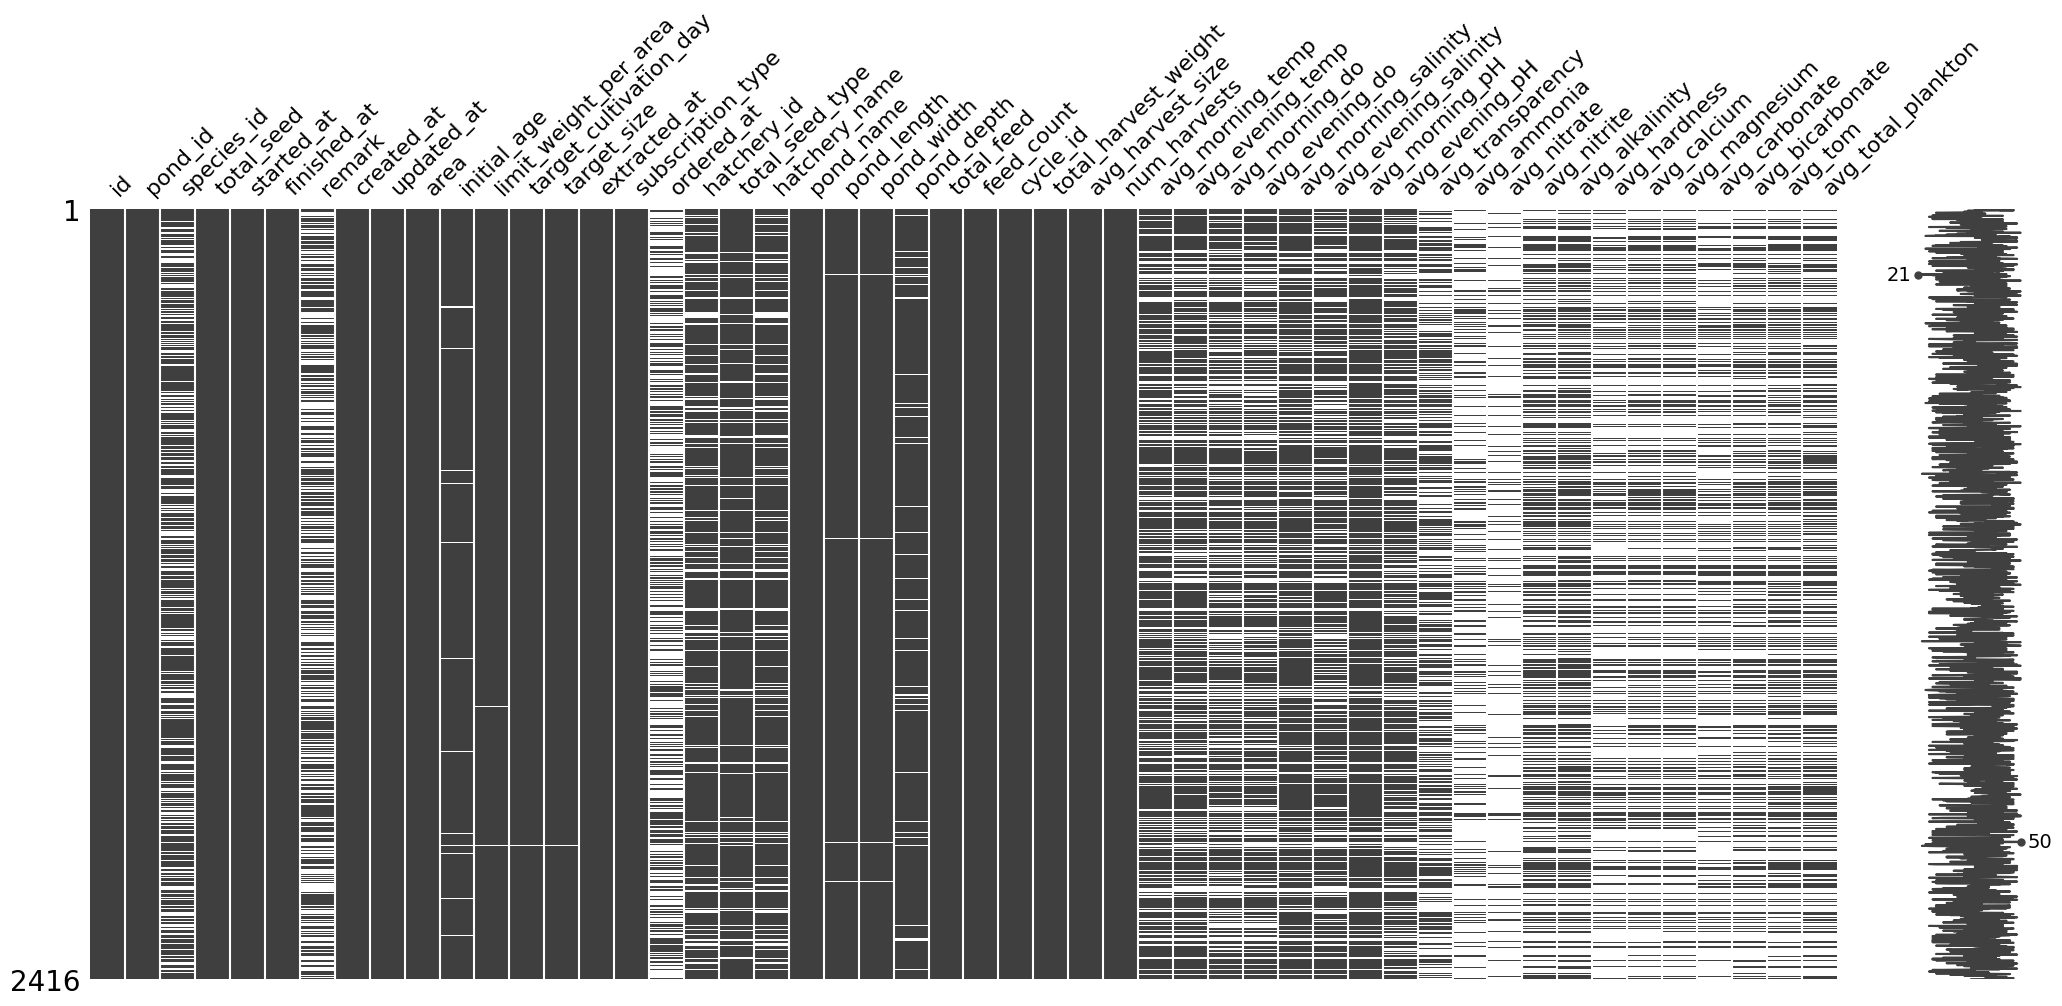

In [31]:
missingno.matrix(cycles_agg)

In [32]:
# Check the number of missing values in each column
missing_values = cycles_agg.isnull().sum()

# Display only columns that have missing values
missing_values = missing_values[missing_values > 0]
print(missing_values)

species_id                 760
remark                    1145
initial_age                 44
limit_weight_per_area        6
target_cultivation_day       2
target_size                  3
ordered_at                1382
hatchery_id                372
total_seed_type            218
hatchery_name              372
pond_length                  6
pond_width                   6
pond_depth                 103
avg_morning_temp           585
avg_evening_temp           638
avg_morning_do             872
avg_evening_do             827
avg_morning_salinity       506
avg_evening_salinity       790
avg_morning_pH             366
avg_evening_pH             736
avg_transparency          1177
avg_ammonia               1840
avg_nitrate               2107
avg_nitrite               1293
avg_alkalinity            1180
avg_hardness              1705
avg_calcium               1582
avg_magnesium             1581
avg_carbonate             1707
avg_bicarbonate           1527
avg_tom                   1438
avg_tota

In [33]:
# Calculate the percentage of null values in each column
null_percentage = cycles_agg.isnull().mean()
print(null_percentage)

# Set a threshold of 50%
threshold = 0.5

# Select columns to drop
columns_to_drop = null_percentage[null_percentage > threshold].index

# Drop columns with more than 50% missing values
cycles_agg_cleaned = cycles_agg.drop(columns=columns_to_drop)

id                        0.000000
pond_id                   0.000000
species_id                0.314570
total_seed                0.000000
started_at                0.000000
finished_at               0.000000
remark                    0.473924
created_at                0.000000
updated_at                0.000000
area                      0.000000
initial_age               0.018212
limit_weight_per_area     0.002483
target_cultivation_day    0.000828
target_size               0.001242
extracted_at              0.000000
subscription_type         0.000000
ordered_at                0.572020
hatchery_id               0.153974
total_seed_type           0.090232
hatchery_name             0.153974
pond_name                 0.000000
pond_length               0.002483
pond_width                0.002483
pond_depth                0.042632
total_feed                0.000000
feed_count                0.000000
cycle_id                  0.000000
total_harvest_weight      0.000000
avg_harvest_size    

In [34]:
# Impute missing values for numerical columns with the median
num_cols = cycles_agg_cleaned.select_dtypes(include=['number']).columns
cycles_agg_cleaned[num_cols] = cycles_agg_cleaned[num_cols].fillna(cycles_agg_cleaned[num_cols].median())

# Impute missing values for categorical columns with the mode
cat_cols = cycles_agg_cleaned.select_dtypes(include=['object']).columns
cycles_agg_cleaned[cat_cols] = cycles_agg_cleaned[cat_cols].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [35]:
df = cycles_agg_cleaned.copy()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2416 non-null   int64  
 1   pond_id                 2416 non-null   int64  
 2   species_id              2416 non-null   float64
 3   total_seed              2416 non-null   int64  
 4   started_at              2416 non-null   object 
 5   finished_at             2416 non-null   object 
 6   remark                  2416 non-null   object 
 7   created_at              2416 non-null   object 
 8   updated_at              2416 non-null   object 
 9   area                    2416 non-null   float64
 10  initial_age             2416 non-null   float64
 11  limit_weight_per_area   2416 non-null   float64
 12  target_cultivation_day  2416 non-null   float64
 13  target_size             2416 non-null   float64
 14  extracted_at            2416 non-null   

## 8. **Feature Engineering**

After data cleaning and aggregation, the next step is **feature engineering**, where new variables are created to improve the predictive performance of the model. These features are based on domain knowledge and are crucial for understanding shrimp survival.

---

### **1. Survival Rate (SR) Calculation**
Survival Rate (SR) is a key metric in shrimp farming that indicates the percentage of shrimp that survive until harvest. It is calculated as:

**SR = (Total Harvest Weight × Average Harvest Size / Total Seed Stocked) × 100**

This formula ensures that SR accurately reflects the proportion of the initial shrimp stock that successfully reaches harvest.

---

### **2. Additional Features for Prediction**
Several new features were created to enhance the model’s ability to predict SR:

#### **Seed Density**
- **Definition**: The number of shrimp stocked per unit area.
- **Formula**:  

  **Seed Density = Total Seed Stocked / Pond Area**

- **Importance**: Higher densities may lead to resource competition, which can affect survival rates.

---

#### **Feed Efficiency Metrics**
To assess feeding efficiency, two key features were introduced:

1. **Feed Per Seed**
   - **Definition**: The total amount of feed given per shrimp.
   - **Formula**:  

     **Feed Per Seed = Total Feed Quantity / Total Seed Stocked**

   - **Relevance**: Indicates whether feeding strategies are optimized.

2. **Feed Per Area**
   - **Definition**: The total amount of feed distributed per unit pond area.
   - **Formula**:  

     **Feed Per Area = Total Feed Quantity / Pond Area**

   - **Relevance**: Helps evaluate how efficiently feed is utilized across different pond sizes.

---

#### **Daily Environmental Changes**
Environmental factors significantly impact shrimp health and survival. Three **delta features** were created to capture daily variations:

1. **Daily Temperature Change**
   - **Definition**: The difference between evening and morning water temperatures.
   - **Formula**:  

     **Delta Temp = Evening Temperature - Morning Temperature**

   - **Importance**: Sudden temperature shifts can stress shrimp and affect growth.

2. **Daily Dissolved Oxygen (DO) Change**
   - **Definition**: The variation in dissolved oxygen levels between morning and evening.
   - **Formula**:  

     **Delta DO = Evening DO - Morning DO**

   - **Importance**: Oxygen fluctuations impact shrimp metabolism and overall health.

3. **Daily pH Change**
   - **Definition**: The variation in pH levels from morning to evening.
   - **Formula**:  

     **Delta pH = Evening pH - Morning pH**

   - **Importance**: Shrimp are sensitive to sudden pH changes, which can lead to higher mortality.

---

### **3. Summary of Feature Engineering**
| **Feature Name**   | **Description**                                    |
|-------------------|--------------------------------------------------|
| `SR`             | Survival Rate (%)                                 |
| `seed_density`   | Shrimp seed density per unit area                 |
| `feed_per_seed`  | Feed efficiency per shrimp                        |
| `feed_per_area`  | Feed efficiency per pond area                     |
| `delta_temp`     | Daily temperature variation                        |
| `delta_DO`       | Daily dissolved oxygen variation                   |
| `delta_pH`       | Daily pH variation                                 |

These features **capture key biological and environmental factors** that influence shrimp survival, providing essential insights for predictive modeling.


In [37]:
# Survival Rate (SR) Calculation
df['SR'] = (df['total_harvest_weight'] * df['avg_harvest_size'] / df['total_seed']) * 100

In [38]:
# Seed Density
df["seed_density"] = df["total_seed"] / df["area"]  # Shrimp seed density per unit area

In [39]:
# Feed Efficiency Metrics
df["feed_per_seed"] = df["total_feed"] / df["total_seed"]  # Feed efficiency per shrimp
df["feed_per_area"] = df["total_feed"] / df["area"]  # Feed efficiency per pond area

In [40]:
# Daily Environmental Changes
df["delta_temp"] = df["avg_evening_temp"] - df["avg_morning_temp"]  # Daily temperature variation
df["delta_DO"] = df["avg_evening_do"] - df["avg_morning_do"]  # Daily dissolved oxygen variation
df["delta_pH"] = df["avg_evening_pH"] - df["avg_morning_pH"]  # Daily pH variation

In [41]:
df['SR'].min()

0.0

In [42]:
df['SR'].max()

80000.0

In [43]:
# Filter out unrealistic survival rate values
df = df[(df['SR'] > 0) & (df['SR'] < 100)]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2228 entries, 0 to 2415
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2228 non-null   int64  
 1   pond_id                 2228 non-null   int64  
 2   species_id              2228 non-null   float64
 3   total_seed              2228 non-null   int64  
 4   started_at              2228 non-null   object 
 5   finished_at             2228 non-null   object 
 6   remark                  2228 non-null   object 
 7   created_at              2228 non-null   object 
 8   updated_at              2228 non-null   object 
 9   area                    2228 non-null   float64
 10  initial_age             2228 non-null   float64
 11  limit_weight_per_area   2228 non-null   float64
 12  target_cultivation_day  2228 non-null   float64
 13  target_size             2228 non-null   float64
 14  extracted_at            2228 non-null   objec

In [45]:
# Drop irrelevant features
drop_columns = [
    "id", "pond_id", "cycle_id", "species_id", "started_at", "finished_at", 
    "created_at", "updated_at", "extracted_at", "remark", "subscription_type", 
    "total_seed_type", "hatchery_id", "hatchery_name", "pond_name", "limit_weight_per_area"
]
df = df.drop(columns=drop_columns, errors="ignore")

## 9. **Modeling**

**Data Splitting**

In [46]:
# Data Splitting
X = df.drop(columns=["SR"])
y = df["SR"]

In [47]:
feature_names = X.columns

**Train and Test Splitting**

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Data Scaling**

In [49]:
# Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Select a Benchmark Model**

In [50]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Store evaluation results
results = []

# Cross-validation settings
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Model benchmarking
for name, model in models.items():
    start_time = time.time()

    # Evaluate model using cross-validation
    scores = {
        "RMSE": cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", error_score=np.nan),
        "MAPE": cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_percentage_error", error_score=np.nan),
        "MAE": cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", error_score=np.nan)
    }

    # Compute execution time
    compute_time = time.time() - start_time

    # Store results
    results.append({
        "Model": name,
        "Mean RMSE": -np.mean(scores["RMSE"]),
        "Std RMSE": np.std(scores["RMSE"]),
        "Mean MAPE": -np.mean(scores["MAPE"]),
        "Std MAPE": np.std(scores["MAPE"]),
        "Mean MAE": -np.mean(scores["MAE"]),
        "Std MAE": np.std(scores["MAE"]),
        "Time (s)": compute_time
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [51]:
results_df

,Model,Mean RMSE,Std RMSE,Mean MAPE,Std MAPE,Mean MAE,Std MAE,Time (s)
0,Linear Regression,28.000810,10.468967,3.272907,4.380553,16.120490,0.848064,0.082378
1,KNN,19.663817,0.169934,1.634260,1.089104,15.022460,0.280119,0.246823
2,Decision Tree,13.959212,0.856189,0.943277,1.197878,9.616182,0.706689,0.680989
3,Random Forest,8.841423,0.622038,0.573032,0.489143,6.342407,0.470602,38.381269
4,XGBoost,7.656312,0.636278,0.343441,0.240151,5.326625,0.382410,2.429540


In [52]:
results_df.loc[results_df['Mean RMSE'] == results_df['Mean RMSE'].max(), 'Model'].iloc[0]

'Linear Regression'

In [53]:
results_df.loc[results_df['Mean MAE'] == results_df['Mean MAE'].max(), 'Model'].iloc[0]

'Linear Regression'

In [54]:
results_df.loc[results_df['Mean MAPE'] == results_df['Mean MAPE'].max(), 'Model'].iloc[0]

'Linear Regression'

**Predict to Test Set with the Benchmark Model**

In [55]:
# Initialize & Train Model
model_before = XGBRegressor(random_state=42)
model_before.fit(X_train, y_train)

# Predictions on Test Set
y_pred = model_before.predict(X_test)

# Compute Evaluation Metrics
score_before_tuning = pd.DataFrame({
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred))],
    "MAE": [mean_absolute_error(y_test, y_pred)],
    "MAPE": [np.mean(np.abs((y_test - y_pred) / y_test))]
}, index=["XGB"])

score_before_tuning

,RMSE,MAE,MAPE
XGB,7.207849,4.677552,0.17937


**Hyper Parameter Tuning**

In [56]:
# Tree depth
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100) / 100)

# Number of trees
n_estimators = list(np.arange(100, 201))

# Percentage of rows used for each tree (fraction of total training set rows)
subsample = list(np.arange(2, 10) / 10)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(1, 11))  # Higher values make the model more conservative/simpler

# Percentage of features used for each tree (fraction of total training set columns)
colsample_bytree = list(np.arange(1, 10) / 10)

# Alpha (regularization)
reg_alpha = list(np.logspace(-3, 1, 10))  # Higher values make the model more conservative/simpler


# Hyperparameter space for XGBoost
hyperparam_space_xgb = {
    'model__max_depth': max_depth,
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [57]:
xgb = XGBRegressor(random_state=42, verbosity=0)

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    xgb, 
    param_distributions = hyperparam_space_xgb,
    n_iter = 50,
    cv = crossval, 
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error',
    random_state = 42  
)

In [58]:
# Fitting data training untuk mencari parameter terbaik
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None...
                                                             0.007742636826811269,
                                                             0.021544346900318832,
                                                             0.05994842503189409,
                                                             0.1668100537200059,
                                                             0.46415888336127775,
                                                             1.2915496650148828,
                                                             3.593813663804626,
                                                             10.0],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=1, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [59]:
# View tuning results in a dataframe, sorted by RMSE, MAE & MAPE
pd.DataFrame(random_xgb.cv_results_).sort_values(
    by=['rank_test_neg_root_mean_squared_error', 
        'rank_test_neg_mean_absolute_error', 
        'rank_test_neg_mean_absolute_percentage_error']
).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.772433,0.034128,0.005376,0.000622,0.7,0.007743,144,2,0.68,10,...,0.38241,1,-0.166874,-0.17545,-0.185075,-0.791652,-0.39815,-0.343441,0.240151,1
1,0.804761,0.036567,0.004904,0.001579,0.9,1.29155,180,1,0.07,1,...,0.38241,1,-0.166874,-0.17545,-0.185075,-0.791652,-0.39815,-0.343441,0.240151,1
2,0.791154,0.010618,0.003598,0.004926,0.3,10.0,123,6,0.79,9,...,0.38241,1,-0.166874,-0.17545,-0.185075,-0.791652,-0.39815,-0.343441,0.240151,1
3,0.763573,0.011891,0.006249,0.007654,0.5,0.021544,166,8,0.1,9,...,0.38241,1,-0.166874,-0.17545,-0.185075,-0.791652,-0.39815,-0.343441,0.240151,1
4,0.760783,0.012087,0.006318,0.004653,0.9,10.0,188,9,0.79,9,...,0.38241,1,-0.166874,-0.17545,-0.185075,-0.791652,-0.39815,-0.343441,0.240151,1


In [60]:
# Check best score and parameters
print('XGBoost')
print('Best score:', random_xgb.best_score_)
print('Best parameters:', random_xgb.best_params_)

XGBoost
Best score: -7.65631173202105
Best parameters: {'model__subsample': 0.7, 'model__reg_alpha': 0.007742636826811269, 'model__n_estimators': 144, 'model__max_depth': 2, 'model__learning_rate': 0.68, 'model__gamma': 10, 'model__colsample_bytree': 0.9}


**Performance Comparison**

In [61]:
# XGBoost Model
model = {'XGB': XGBRegressor(random_state=42)}

# Define model with the best estimator
xgb_tuning = random_xgb.best_estimator_

# Fit the model
xgb_tuning.fit(X_train, y_train)

# Predict the test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Store RMSE, MAE & MAPE metrics after tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

,RMSE,MAE,MAPE
XGB,7.207849,4.677552,0.17937


In [62]:
# Before hyperparameter tuning
pd.DataFrame(score_before_tuning.loc['XGB']).T

,RMSE,MAE,MAPE
XGB,7.207849,4.677552,0.17937


The model may not improve after hyperparameter tuning because the provided data might not be complete.

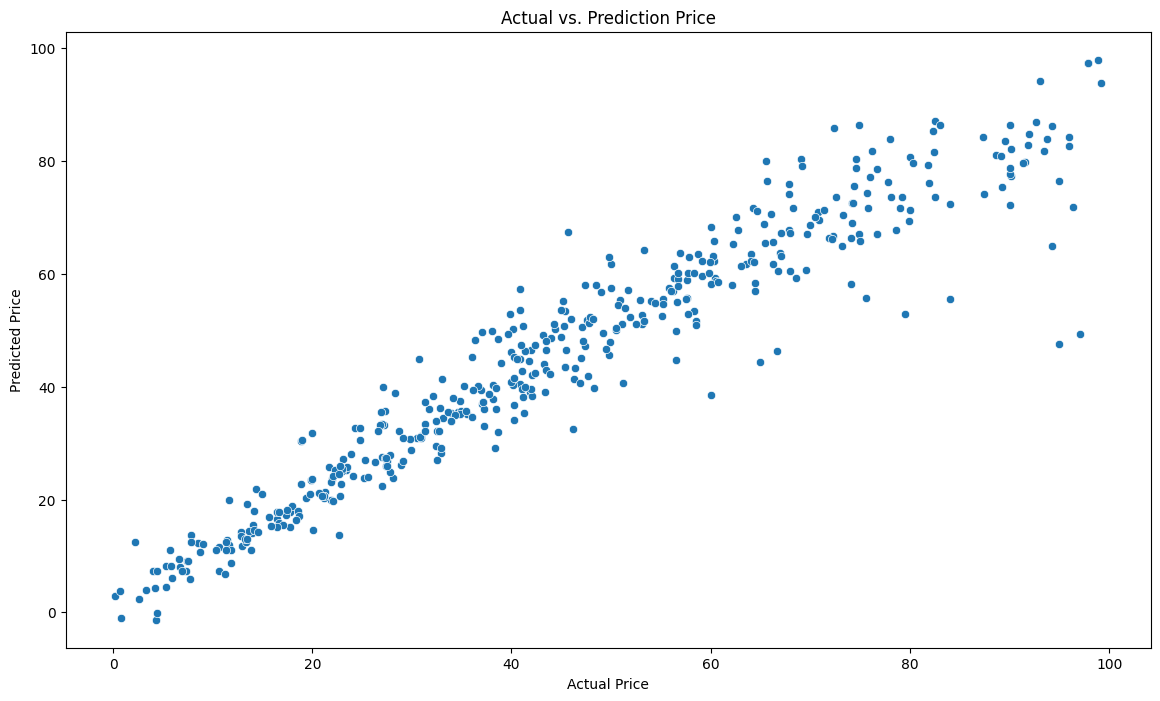

In [63]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(title='Actual vs. Prediction Price', 
                                               xlabel='Actual Price', 
                                               ylabel='Predicted Price');

**Feature Importance**

C:\Users\giova\AppData\Local\Temp\ipykernel_6436\1281531505.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="Blues_r")


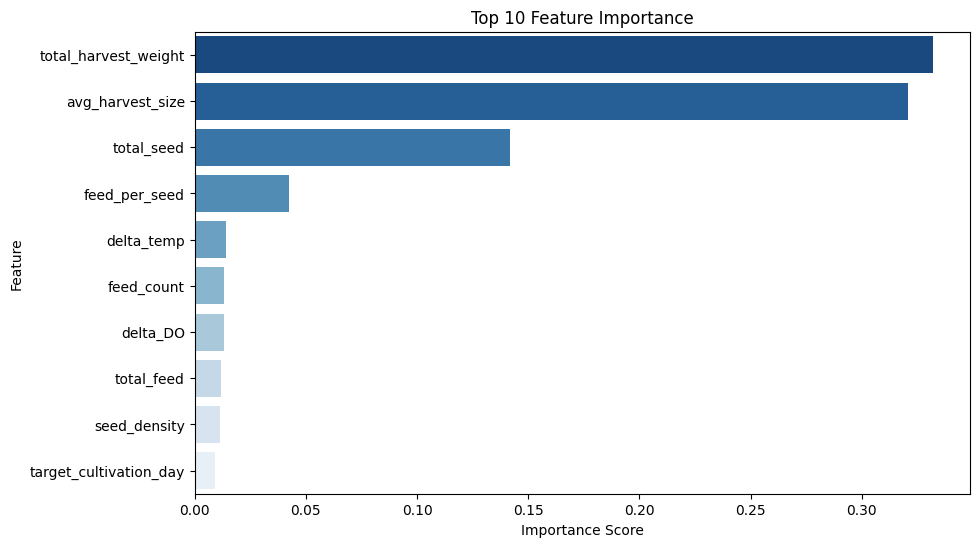

In [64]:
# Extract feature importance
importance = model_before.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,  # Replace with actual feature names
    "Importance": importance
}).sort_values(by="Importance", ascending=False).head(10)  # Top 10 features

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="Blues_r")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance")
plt.show()


In [65]:
feature_importance_df

,Feature,Importance
10,total_harvest_weight,0.331869
11,avg_harvest_size,0.320590
0,total_seed,0.141707
24,feed_per_seed,0.042379
26,delta_temp,0.014124
9,feed_count,0.013373
27,delta_DO,0.013096
8,total_feed,0.011700
23,seed_density,0.011200
3,target_cultivation_day,0.009258


## 10. **Conclusion**  

### **Model Performance Summary**  
- The model achieved a **MAPE of 17.94%**, indicating an **accuracy of approximately 82.06%** in predicting **Survival Rate (SR)**.  
- While this is a **reasonably good result**, the **RMSE (7.21) and MAE (4.68)** suggest that further refinements are necessary to reduce prediction errors and improve reliability in real-world applications.  

### **Key Feature Insights**  
An analysis of **feature importance** reveals that the most influential factors in predicting SR are:  

1. **Total Harvest Weight** (0.33)  
2. **Average Harvest Size** (0.32)  
3. **Total Seed** (0.14)  
4. **Feed Efficiency per Seed** (0.042)  
5. **Temperature Fluctuation** (0.014)    

These results emphasize the significant impact of **harvest metrics, stocking density, and environmental conditions** on shrimp survival.  

### **Potential Areas for Improvement**  
- **Feature Engineering**: Incorporating additional water quality indicators or refining existing features (e.g., trend-based variables) may enhance model accuracy.  
- **Hyperparameter Tuning**: While tuning was performed, it did not yield improvements, possibly due to **data limitations**. More advanced techniques (Bayesian Optimization, Genetic Algorithms) could be explored.  
- **Alternative Models**: Testing ensemble methods such as **LightGBM, Random Forest, or Stacking Approaches** could improve robustness.  

### **Implications for Shrimp Farming**  
- Despite its **promising accuracy**, the model should be **continuously monitored and updated** as new farming cycles provide fresh data.  
- Predictive modeling of SR can **help farmers optimize feeding schedules, water treatment, and aeration management**, leading to **better survival rates and higher profits**.  

Ultimately, while the current model provides **valuable insights**, further refinements are required to **enhance accuracy and ensure practical applicability** in real-world shrimp farming operations.